In [1]:
import logging

import numpy as np
import probtorch
import torch

import dynamical_ball
import bouncing_ball_data
import combinators
import foldable
import importance
import mcmc
import utils

In [2]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [5]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [6]:
num_particles = (100,)

In [7]:
init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)

In [8]:
bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)

In [9]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['velocity_%d' % i] = displacements[i-1]
    
    return trajectory, displacements, data

In [10]:
def accumulate_trajectory(inference):
    result = torch.zeros(num_particles[0], len(trajectory), 2)
    result[:, 0] = inference['Reduce/Foldable(0)/InitBallDynamics']['position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['Reduce/Foldable(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value
    return result

In [11]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [12]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [13]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [14]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [15]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [16]:
def training_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    initializer = combinators.GuidedConditioning(init_bouncing_ball, init_proposal)
    return foldable.Reduce(foldable.Foldable(bouncing_ball_step, initializer=initializer), lambda: range(T))

In [17]:
def posterior_model(init_proposal):
    initializer = combinators.GuidedConditioning(init_bouncing_ball, init_proposal)
    return mcmc.reduce_resample_move_smc(bouncing_ball_step, lambda: range(T), initializer=initializer)

02/13/2019 10:37:48 ELBO=-8.99169922e+02 at epoch 1
02/13/2019 10:37:49 ELBO=-8.10777893e+02 at epoch 2
02/13/2019 10:37:49 ELBO=-8.82093994e+02 at epoch 3
02/13/2019 10:37:49 ELBO=-8.48971252e+02 at epoch 4
02/13/2019 10:37:49 ELBO=-9.69827087e+02 at epoch 5
02/13/2019 10:37:49 ELBO=-7.77512939e+02 at epoch 6
02/13/2019 10:37:49 ELBO=-9.21882568e+02 at epoch 7
02/13/2019 10:37:50 ELBO=-8.37318359e+02 at epoch 8
02/13/2019 10:37:50 ELBO=-7.83290161e+02 at epoch 9
02/13/2019 10:37:50 ELBO=-7.89294800e+02 at epoch 10
02/13/2019 10:37:50 ELBO=-7.41060608e+02 at epoch 11
02/13/2019 10:37:50 ELBO=-9.18580261e+02 at epoch 12
02/13/2019 10:37:50 ELBO=-7.91098511e+02 at epoch 13
02/13/2019 10:37:51 ELBO=-7.67592529e+02 at epoch 14
02/13/2019 10:37:51 ELBO=-7.82404602e+02 at epoch 15
02/13/2019 10:37:51 ELBO=-7.72910461e+02 at epoch 16
02/13/2019 10:37:51 ELBO=-8.39152771e+02 at epoch 17
02/13/2019 10:37:51 ELBO=-7.89930542e+02 at epoch 18
02/13/2019 10:37:51 ELBO=-8.44684326e+02 at epoch 19
02

Epoch   506: reducing learning rate of group 0 to 5.0000e-02.


02/13/2019 10:39:09 ELBO=-7.02239624e+02 at epoch 509
02/13/2019 10:39:09 ELBO=-7.01688660e+02 at epoch 510
02/13/2019 10:39:10 ELBO=-6.99940308e+02 at epoch 511
02/13/2019 10:39:10 ELBO=-7.02597351e+02 at epoch 512
02/13/2019 10:39:10 ELBO=-7.01889832e+02 at epoch 513
02/13/2019 10:39:10 ELBO=-7.00839600e+02 at epoch 514
02/13/2019 10:39:10 ELBO=-7.04121216e+02 at epoch 515
02/13/2019 10:39:10 ELBO=-7.03319580e+02 at epoch 516
02/13/2019 10:39:10 ELBO=-6.99690735e+02 at epoch 517
02/13/2019 10:39:11 ELBO=-7.00824036e+02 at epoch 518
02/13/2019 10:39:11 ELBO=-6.99219421e+02 at epoch 519
02/13/2019 10:39:11 ELBO=-6.99157715e+02 at epoch 520
02/13/2019 10:39:11 ELBO=-7.00159119e+02 at epoch 521
02/13/2019 10:39:11 ELBO=-6.93587646e+02 at epoch 522
02/13/2019 10:39:11 ELBO=-6.98251892e+02 at epoch 523
02/13/2019 10:39:12 ELBO=-6.95683411e+02 at epoch 524
02/13/2019 10:39:12 ELBO=-6.96656738e+02 at epoch 525
02/13/2019 10:39:12 ELBO=-6.98450012e+02 at epoch 526
02/13/2019 10:39:12 ELBO=-6.

Epoch   707: reducing learning rate of group 0 to 2.5000e-02.


02/13/2019 10:39:41 ELBO=-6.99418884e+02 at epoch 710
02/13/2019 10:39:41 ELBO=-6.97963379e+02 at epoch 711
02/13/2019 10:39:41 ELBO=-6.97523010e+02 at epoch 712
02/13/2019 10:39:41 ELBO=-6.96257141e+02 at epoch 713
02/13/2019 10:39:41 ELBO=-7.02521484e+02 at epoch 714
02/13/2019 10:39:41 ELBO=-6.99930908e+02 at epoch 715
02/13/2019 10:39:42 ELBO=-6.98610413e+02 at epoch 716
02/13/2019 10:39:42 ELBO=-7.00830505e+02 at epoch 717
02/13/2019 10:39:42 ELBO=-6.99544922e+02 at epoch 718
02/13/2019 10:39:42 ELBO=-7.03021667e+02 at epoch 719
02/13/2019 10:39:42 ELBO=-6.99736084e+02 at epoch 720
02/13/2019 10:39:42 ELBO=-6.99675842e+02 at epoch 721
02/13/2019 10:39:43 ELBO=-6.99955383e+02 at epoch 722
02/13/2019 10:39:43 ELBO=-6.96748413e+02 at epoch 723
02/13/2019 10:39:43 ELBO=-7.00291138e+02 at epoch 724
02/13/2019 10:39:43 ELBO=-6.99139893e+02 at epoch 725
02/13/2019 10:39:43 ELBO=-6.99043945e+02 at epoch 726
02/13/2019 10:39:43 ELBO=-6.98938416e+02 at epoch 727
02/13/2019 10:39:44 ELBO=-7.

Epoch   908: reducing learning rate of group 0 to 1.2500e-02.


02/13/2019 10:40:13 ELBO=-6.97626709e+02 at epoch 911
02/13/2019 10:40:13 ELBO=-7.01654907e+02 at epoch 912
02/13/2019 10:40:13 ELBO=-6.95746277e+02 at epoch 913
02/13/2019 10:40:13 ELBO=-7.01035828e+02 at epoch 914
02/13/2019 10:40:13 ELBO=-6.91219666e+02 at epoch 915
02/13/2019 10:40:14 ELBO=-6.98153992e+02 at epoch 916
02/13/2019 10:40:14 ELBO=-6.97611328e+02 at epoch 917
02/13/2019 10:40:14 ELBO=-7.00381042e+02 at epoch 918
02/13/2019 10:40:14 ELBO=-6.96234375e+02 at epoch 919
02/13/2019 10:40:14 ELBO=-6.99795044e+02 at epoch 920
02/13/2019 10:40:14 ELBO=-6.95693848e+02 at epoch 921
02/13/2019 10:40:14 ELBO=-6.96906067e+02 at epoch 922
02/13/2019 10:40:15 ELBO=-7.00515259e+02 at epoch 923
02/13/2019 10:40:15 ELBO=-6.99257874e+02 at epoch 924
02/13/2019 10:40:15 ELBO=-6.96696472e+02 at epoch 925
02/13/2019 10:40:15 ELBO=-6.98954956e+02 at epoch 926
02/13/2019 10:40:15 ELBO=-6.97715637e+02 at epoch 927
02/13/2019 10:40:15 ELBO=-7.00292542e+02 at epoch 928
02/13/2019 10:40:16 ELBO=-6.

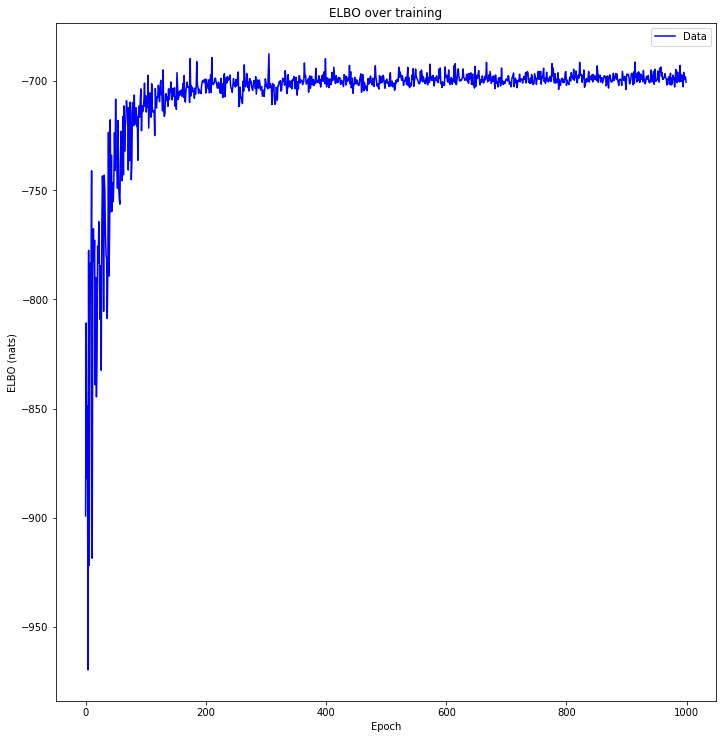

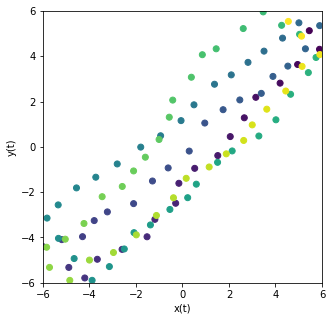

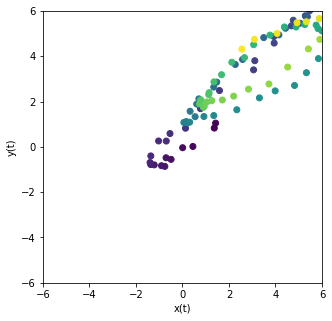

In [18]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    importance_sampler = training_model()
    
    inference, trained_params, elbos = importance.variational_importance(
        importance_sampler, 1000, data,
        use_cuda=False, lr=1e-1, inclusive_kl=False,
        patience=200,
    )
    utils.plot_evidence_bounds(elbos, True)
    
    bouncing_ball_posterior = posterior_model(importance_sampler.folder._initializer)
    (boundary, dynamics, uncertainty, noise, position), inference, _ = bouncing_ball_posterior(data=data)
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Foldable(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_original_trajectory(trajectory, T, s)
    graph_inferred_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    plt.close('all')

In [19]:
trained_params

"{'boundary__loc': 'tensor(-1.9100, grad_fn=<CloneBackward>)', 'boundary__scale': 'tensor(0.0586, grad_fn=<CloneBackward>)', 'dynamics__loc': 'tensor([[-0.0293, -0.0742],\n        [ 0.0439,  0.0640]], grad_fn=<CloneBackward>)', 'dynamics__scale': 'tensor([[-1.7146, -1.9666],\n        [-2.2686, -2.0765]], grad_fn=<CloneBackward>)', 'noise__loc': 'tensor([1.9451, 1.9134], grad_fn=<CloneBackward>)', 'noise__scale': 'tensor([-2.3659, -2.4852], grad_fn=<CloneBackward>)', 'position_0__covariance_matrix': 'tensor([[0.8327, 0.0000],\n        [0.0989, 0.8136]], grad_fn=<CloneBackward>)', 'position_0__loc': 'tensor([1.3769, 1.0514], grad_fn=<CloneBackward>)', 'uncertainty__loc': 'tensor([-1.4927, -1.5307], grad_fn=<CloneBackward>)', 'uncertainty__scale': 'tensor([-0.1050, -0.0772], grad_fn=<CloneBackward>)'}"

In [20]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])

Position at time 0 tensor([5.4556, 5.1309])
Position at time 1 tensor([5.8955, 4.3093])
Position at time 2 tensor([4.9532, 3.6385])
Position at time 3 tensor([4.1997, 2.8152])
Position at time 4 tensor([3.1552, 2.1892])
Position at time 5 tensor([2.6602, 1.2852])
Position at time 6 tensor([2.0562, 0.4556])
Position at time 7 tensor([ 1.5193, -0.3824])
Position at time 8 tensor([ 0.5271, -0.9465])
Position at time 9 tensor([-0.1537, -1.6067])
Position at time 10 tensor([-0.2912, -2.4884])
Position at time 11 tensor([-1.1851, -3.1986])
Position at time 12 tensor([-1.5229, -3.9676])
Position at time 13 tensor([-2.5969, -4.5240])
Position at time 14 tensor([-3.6619, -4.9610])
Position at time 15 tensor([-4.2016, -5.7867])
Position at time 16 tensor([-4.8880, -5.3207])
Position at time 17 tensor([-5.9959, -4.4046])
Position at time 18 tensor([-5.1915, -4.0940])
Position at time 19 tensor([-4.2980, -3.9632])
Position at time 20 tensor([-3.7949, -3.2532])
Position at time 21 tensor([-3.2293, 

In [21]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

Inferred position at time 0 tensor([1.3691, 0.8306])
Inferred position at time 1 tensor([1.4263, 1.0504])
Inferred position at time 2 tensor([0.4495, 0.0186])
Inferred position at time 3 tensor([ 0.0082, -0.0365])
Inferred position at time 4 tensor([-0.4890, -0.5499])
Inferred position at time 5 tensor([-0.7058, -0.4801])
Inferred position at time 6 tensor([-0.7578, -0.8606])
Inferred position at time 7 tensor([-0.9001, -0.8300])
Inferred position at time 8 tensor([-1.2126, -0.7932])
Inferred position at time 9 tensor([-1.3635, -0.7801])
Inferred position at time 10 tensor([-1.3936, -0.6897])
Inferred position at time 11 tensor([-1.3598, -0.3982])
Inferred position at time 12 tensor([-1.0258,  0.2618])
Inferred position at time 13 tensor([-0.6957,  0.2580])
Inferred position at time 14 tensor([-0.5354,  0.5894])
Inferred position at time 15 tensor([0.1319, 0.8240])
Inferred position at time 16 tensor([0.7753, 1.6886])
Inferred position at time 17 tensor([1.5939, 2.4880])
Inferred posit